# Data Loading

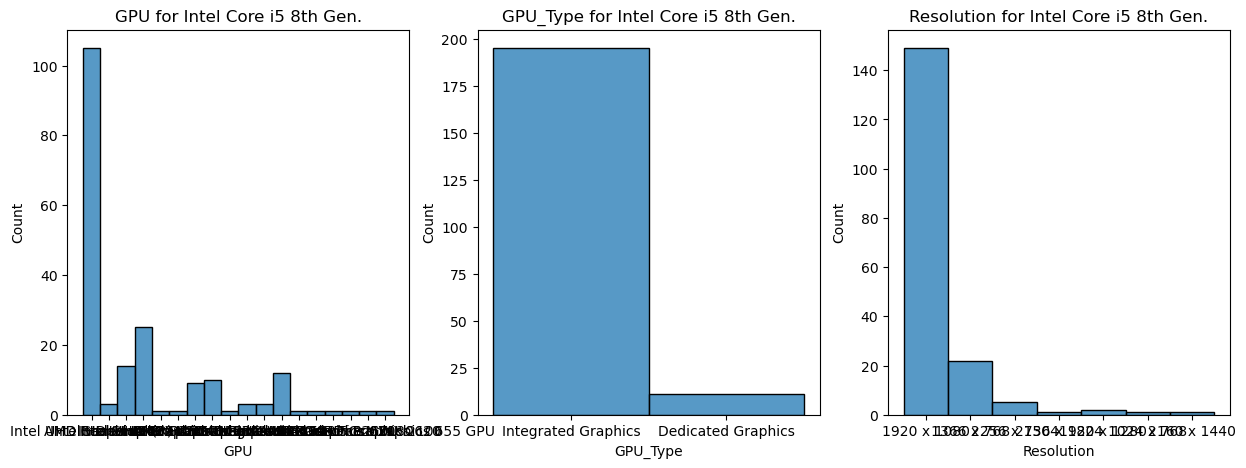

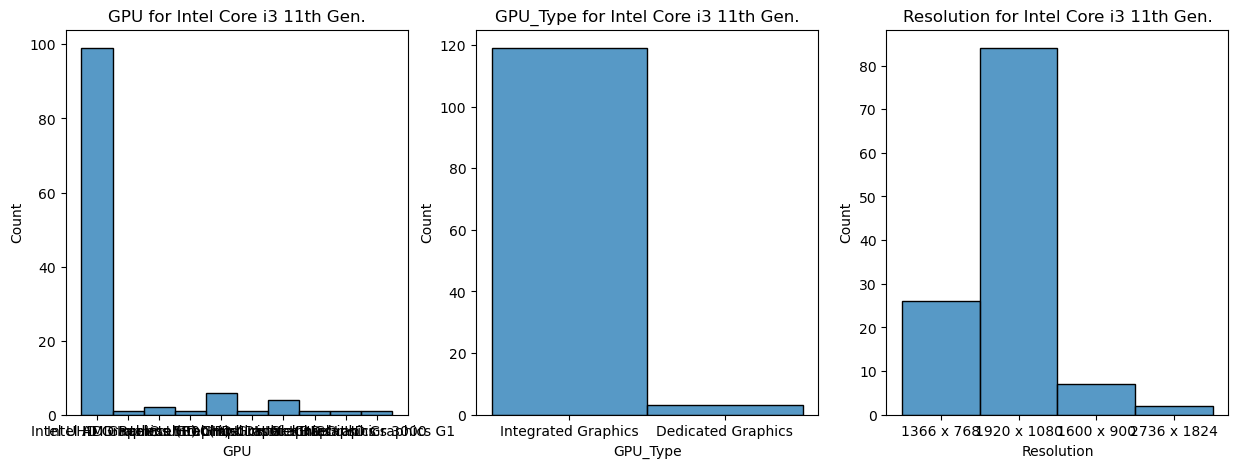

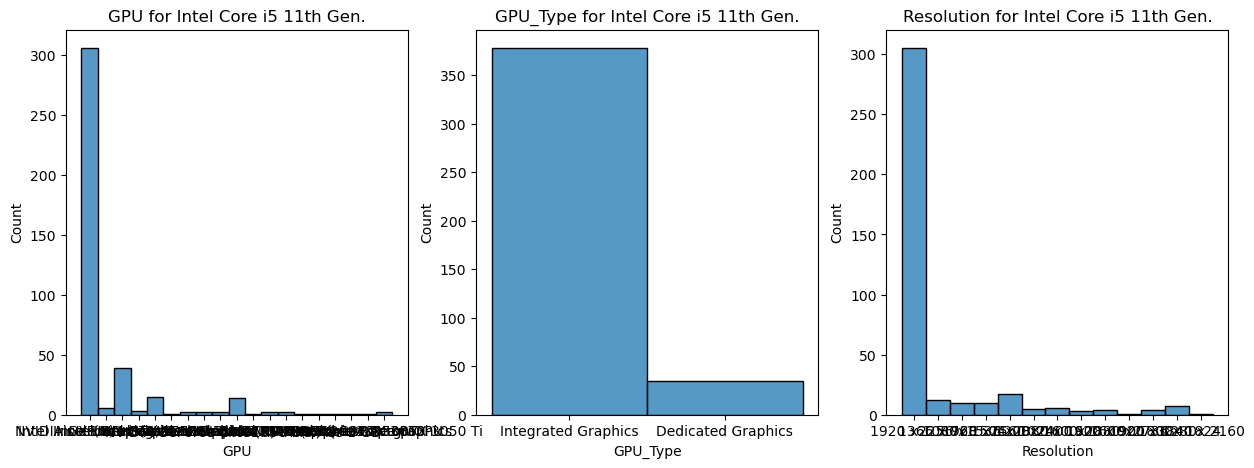

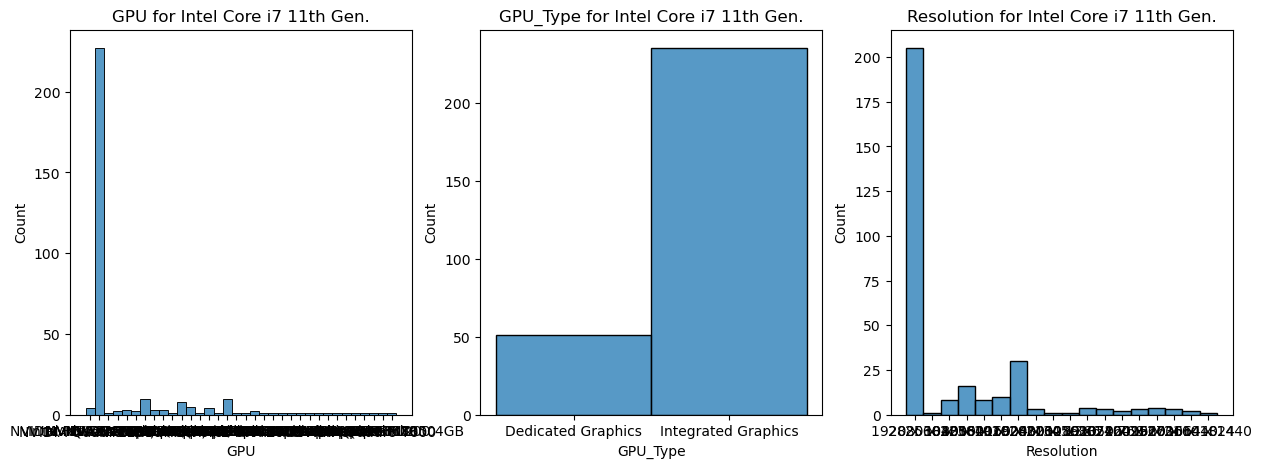

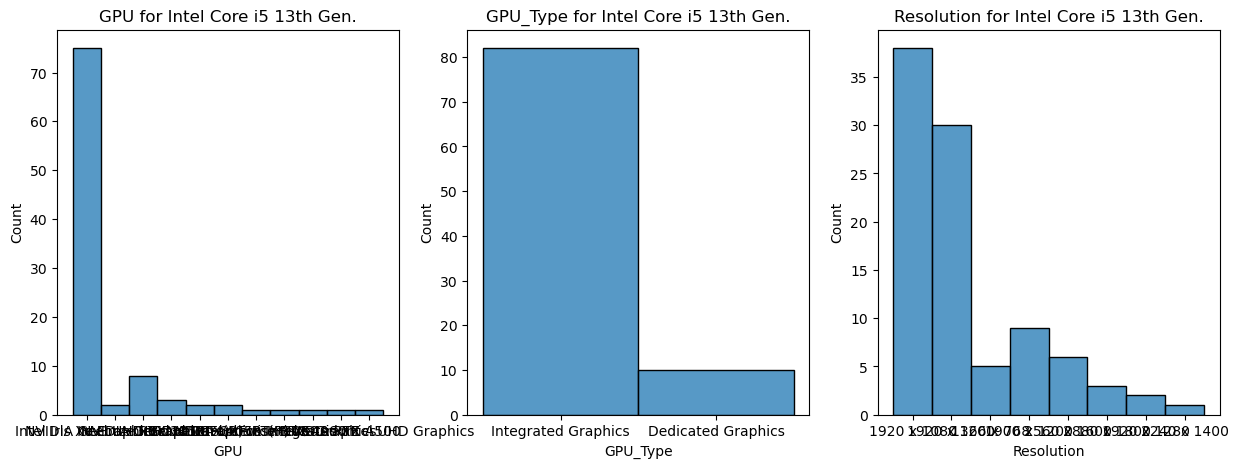

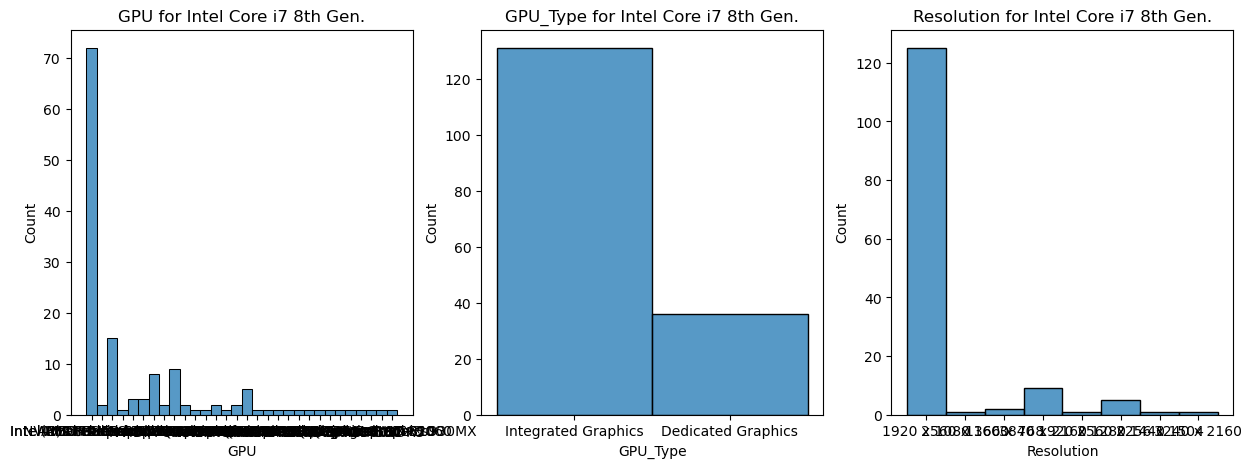

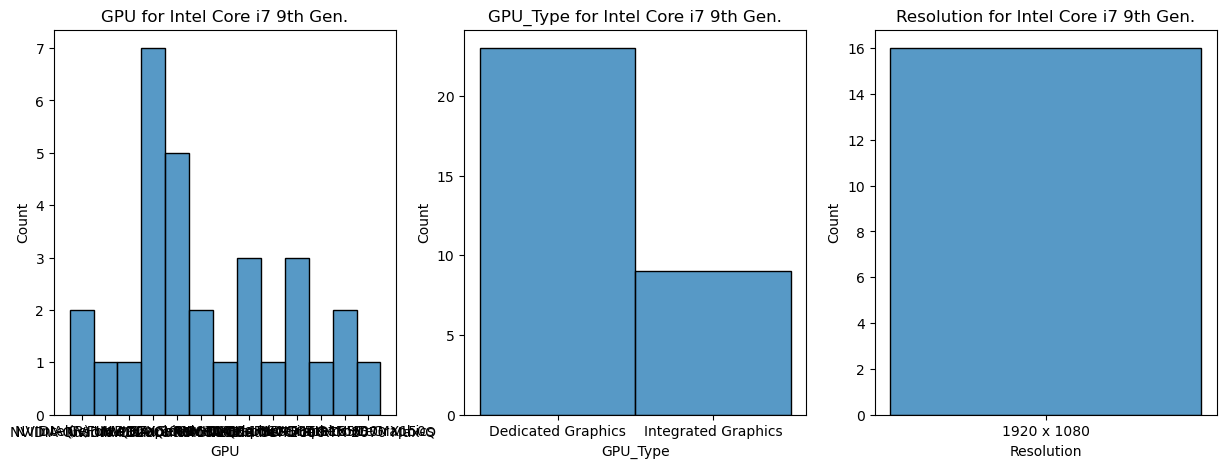

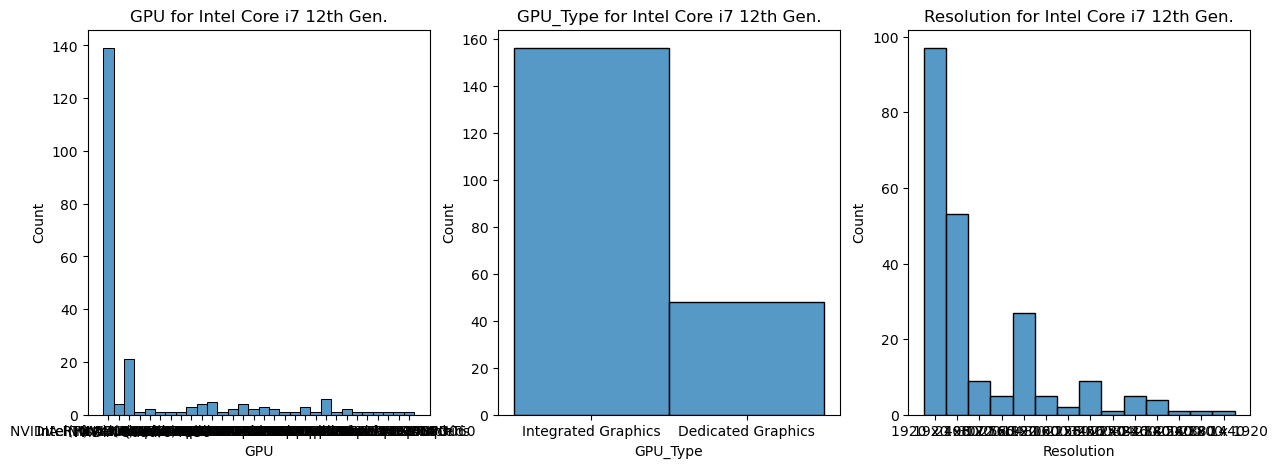

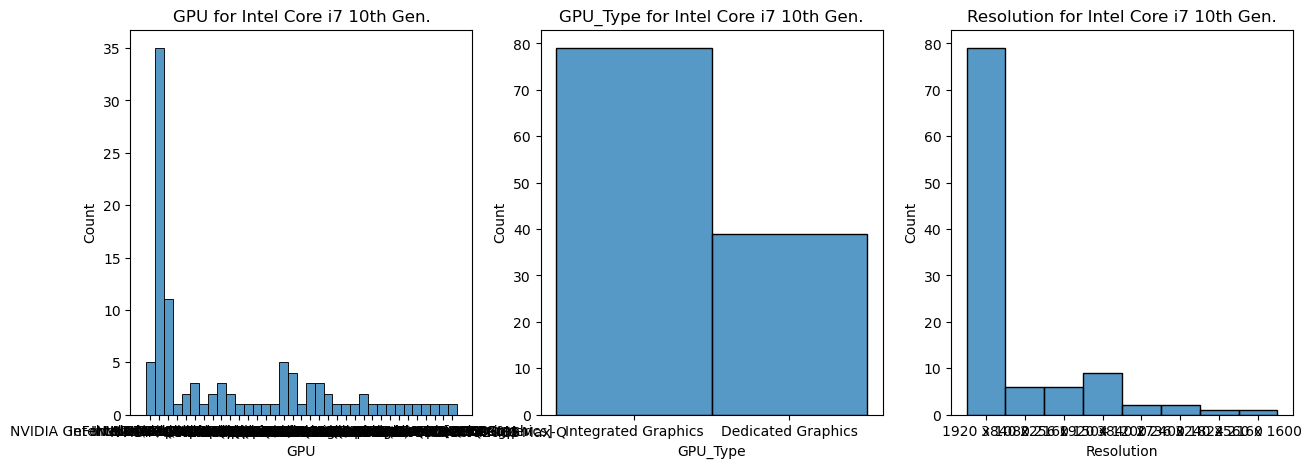

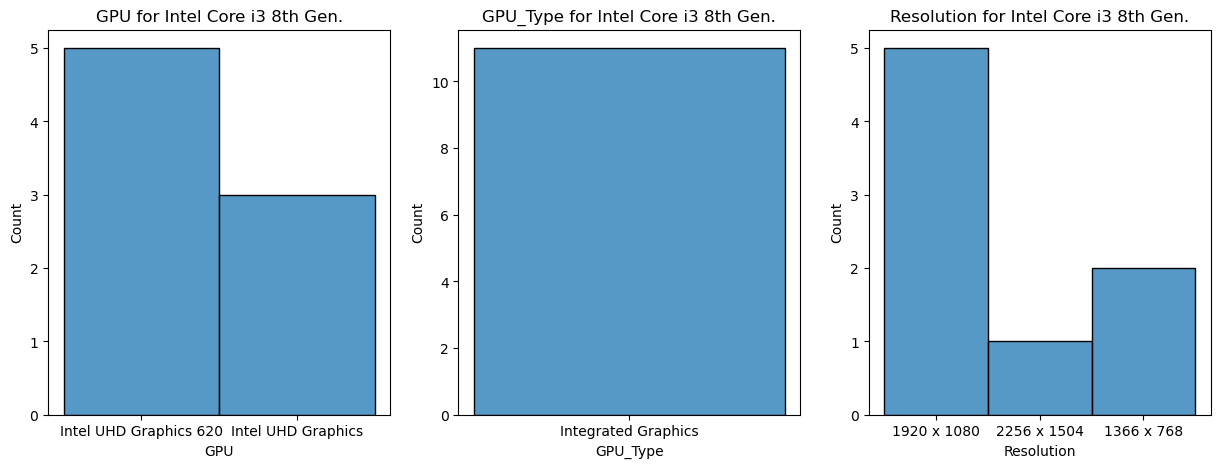

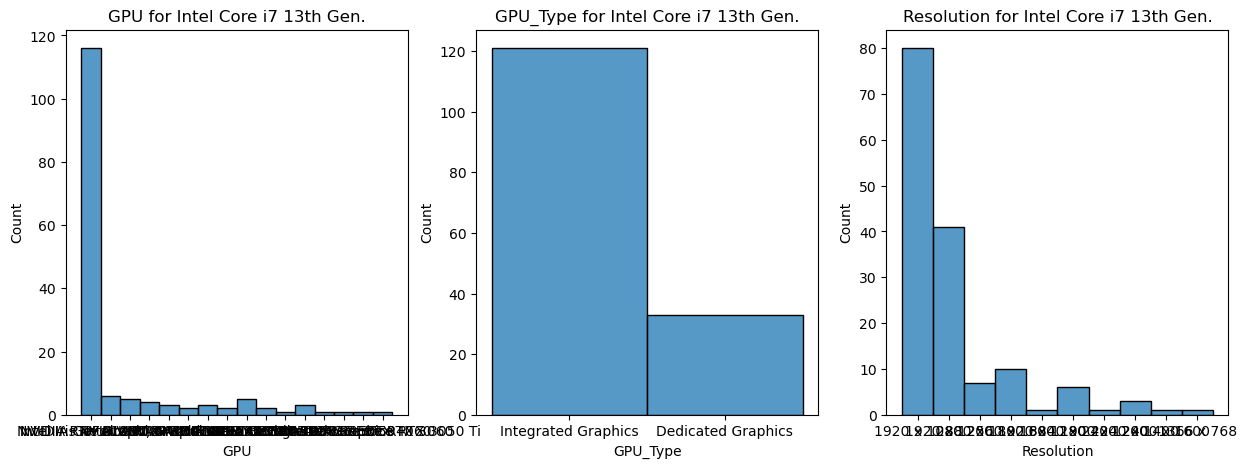

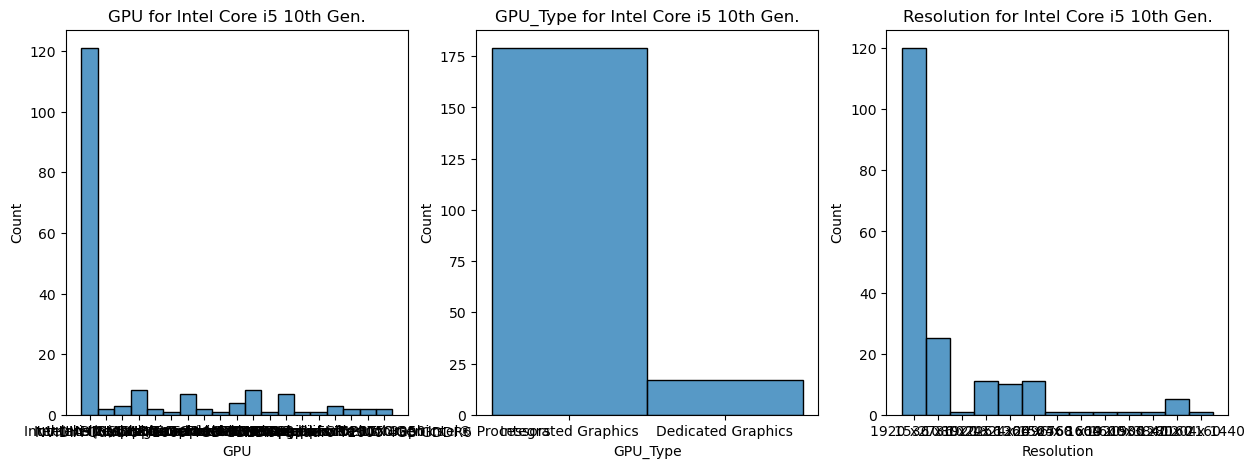

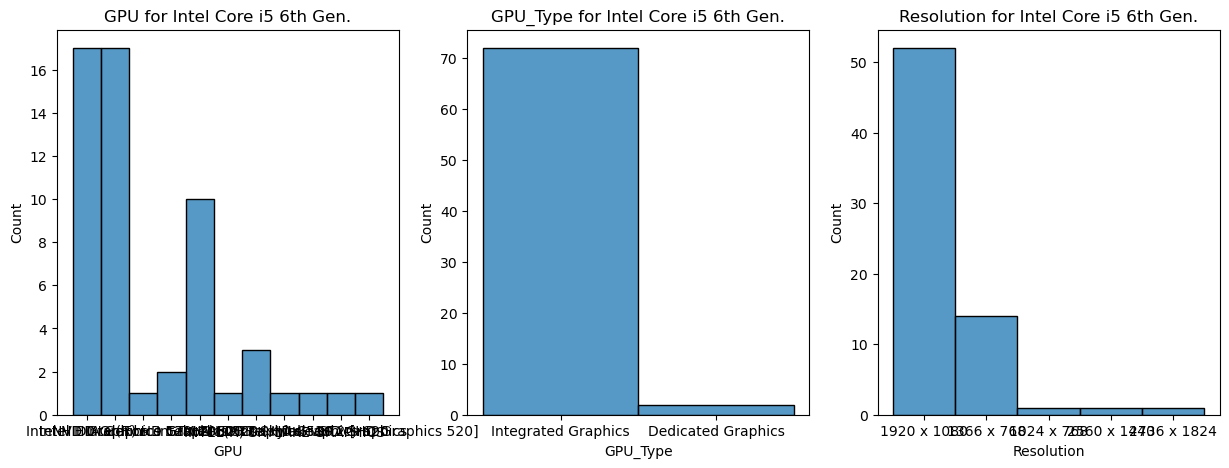

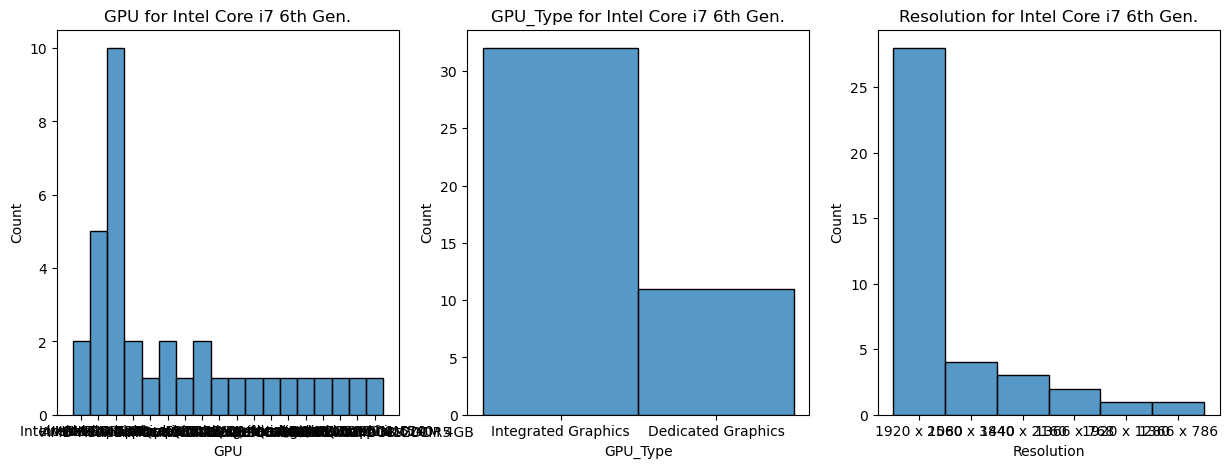

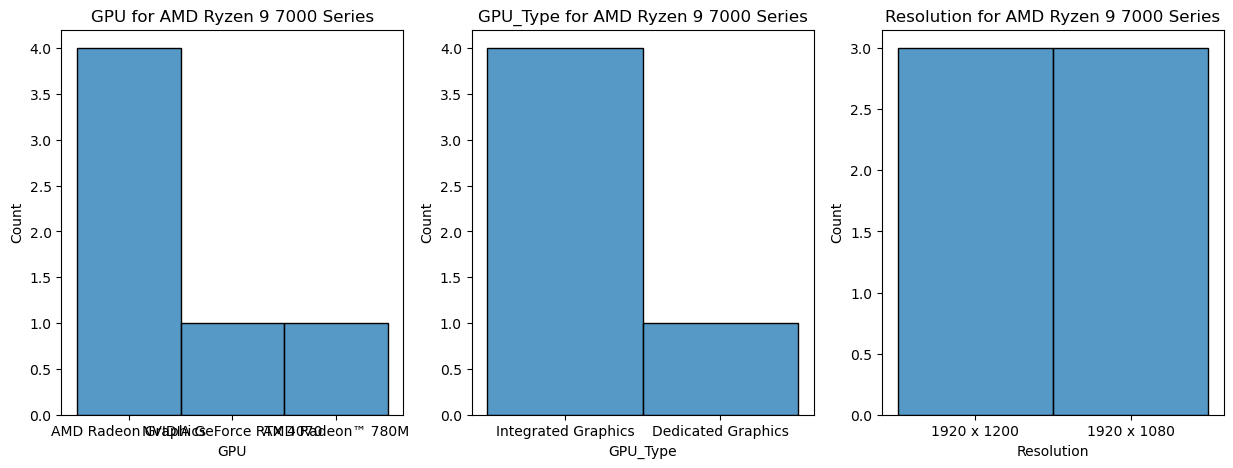

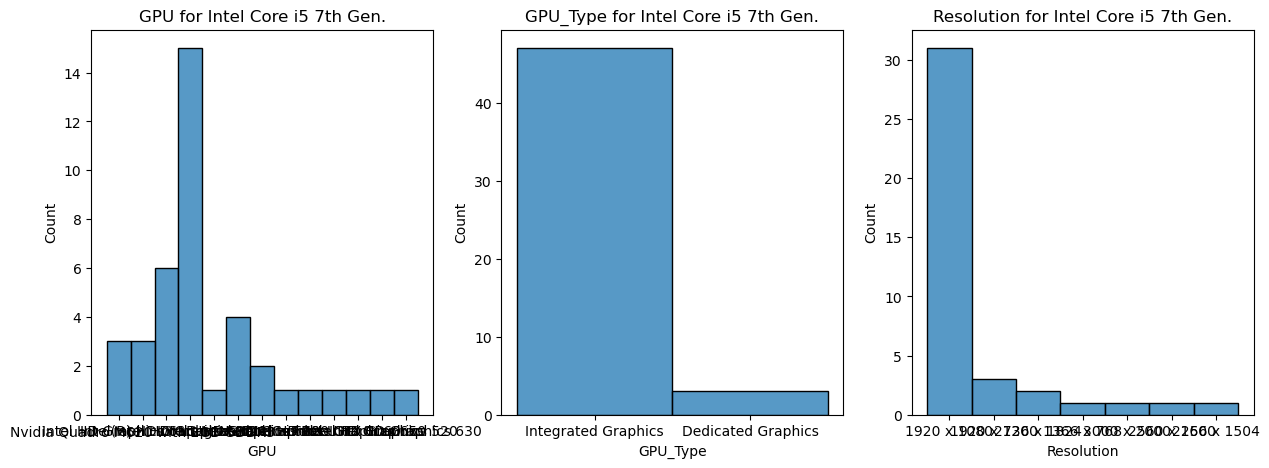

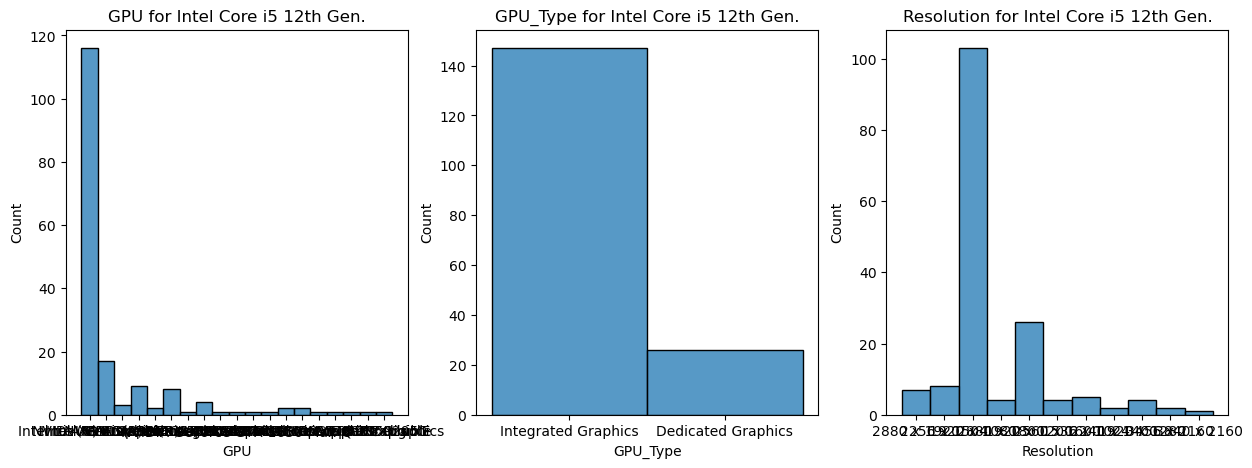

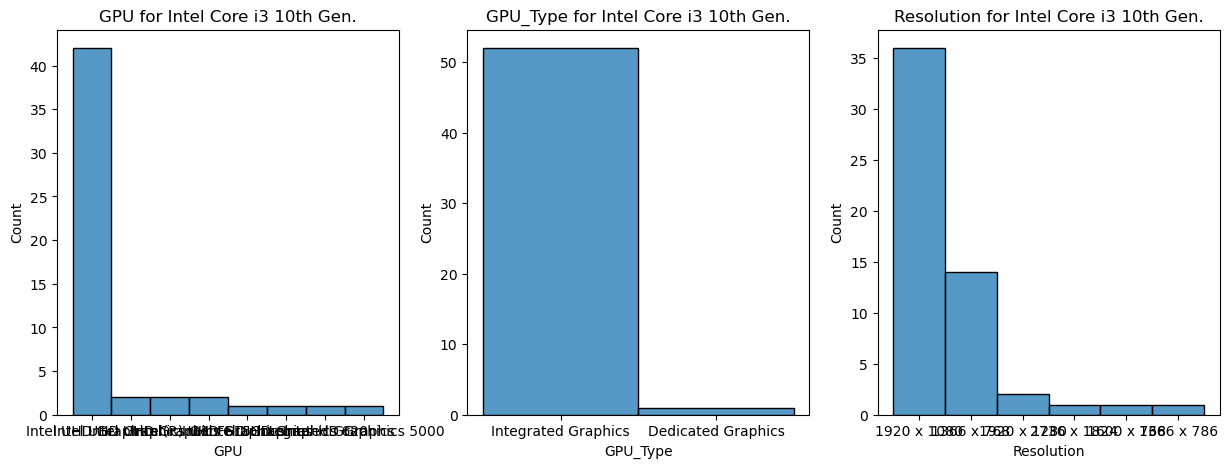

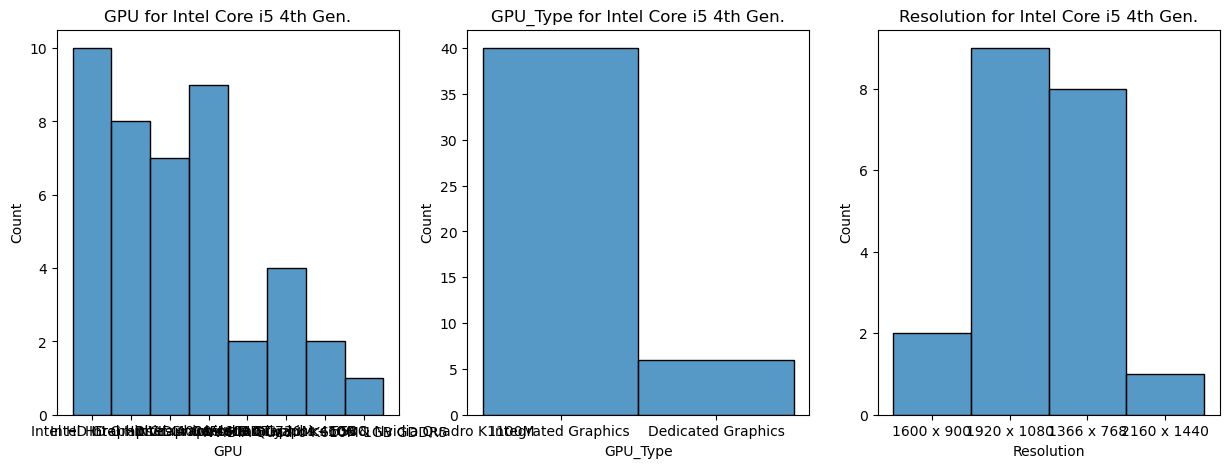

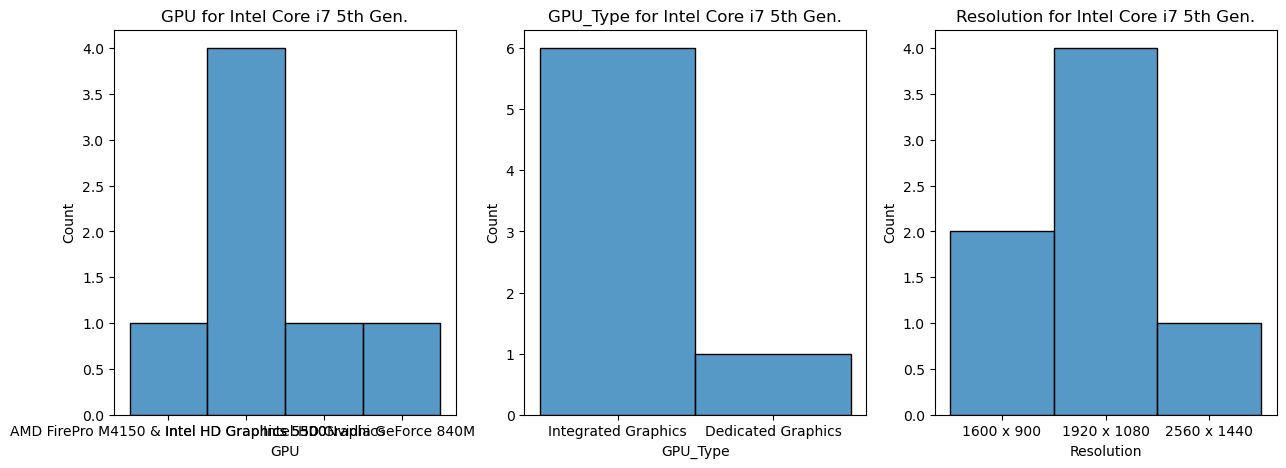

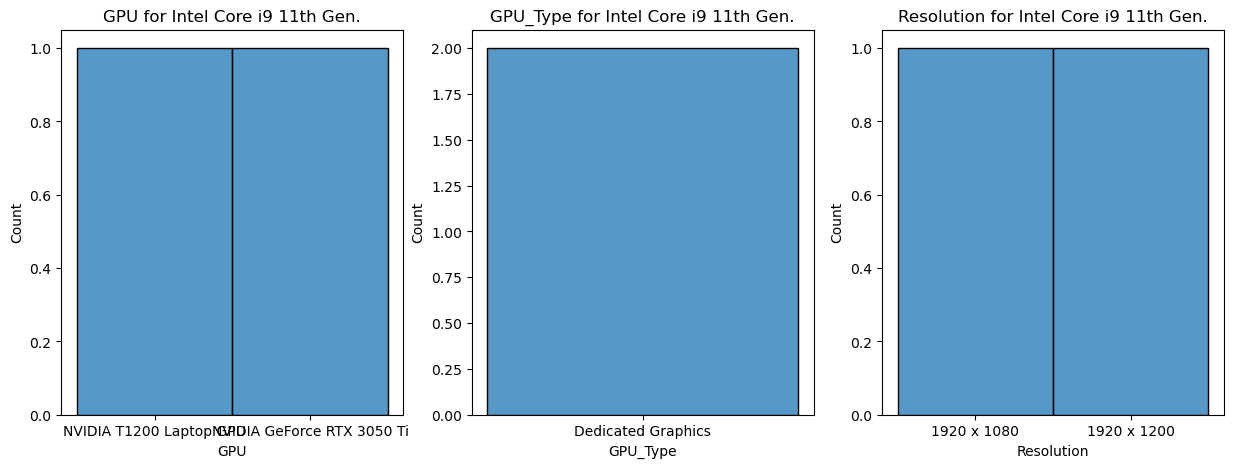

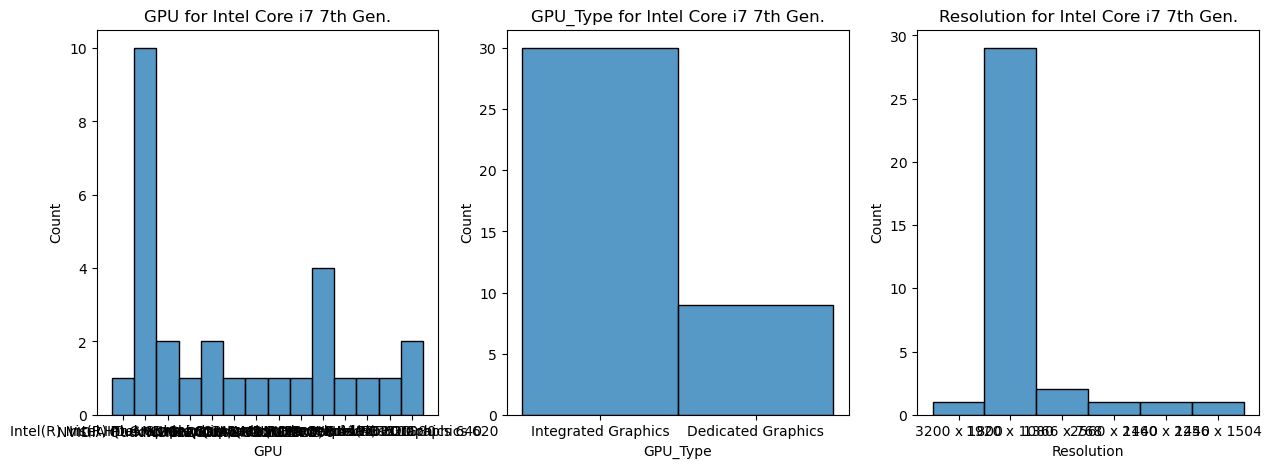

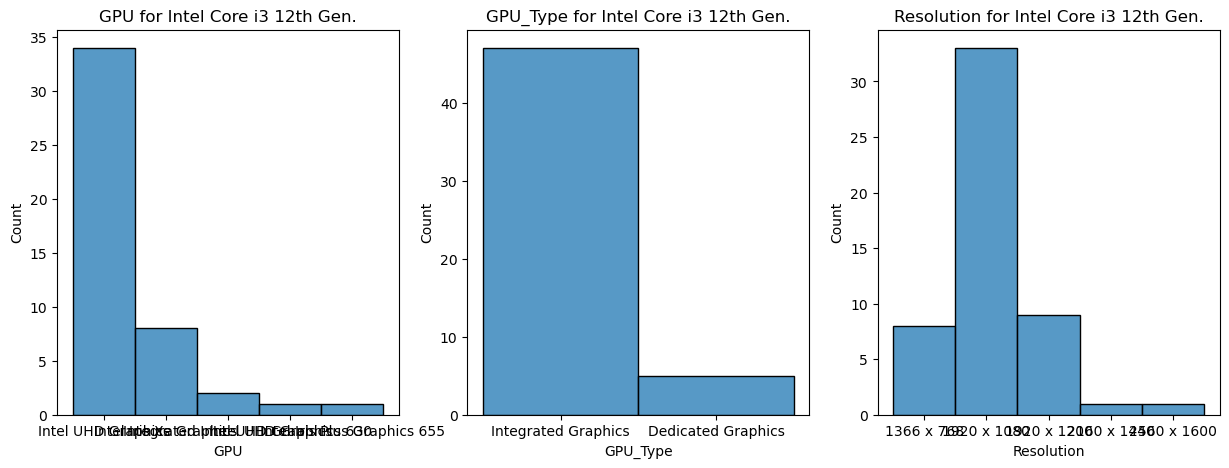

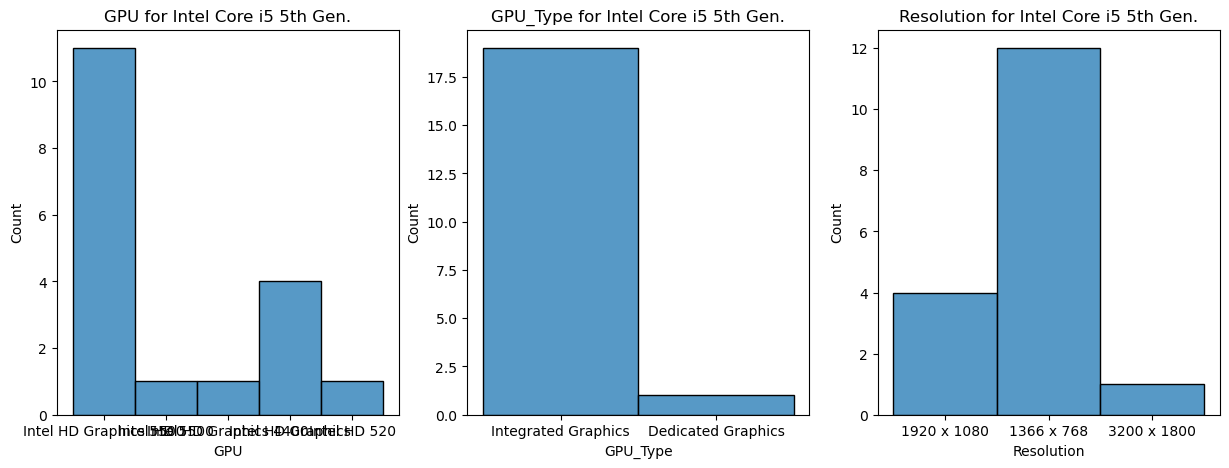

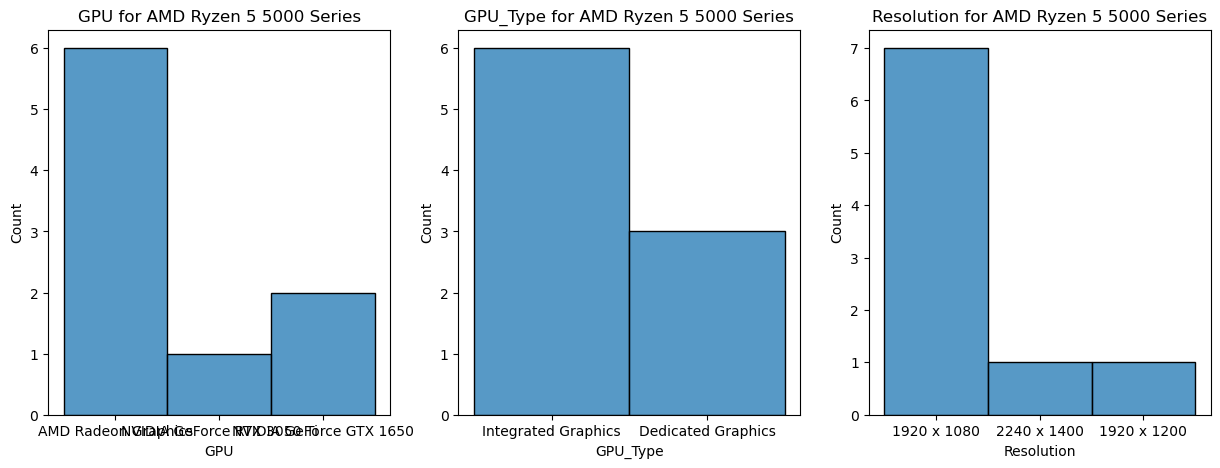

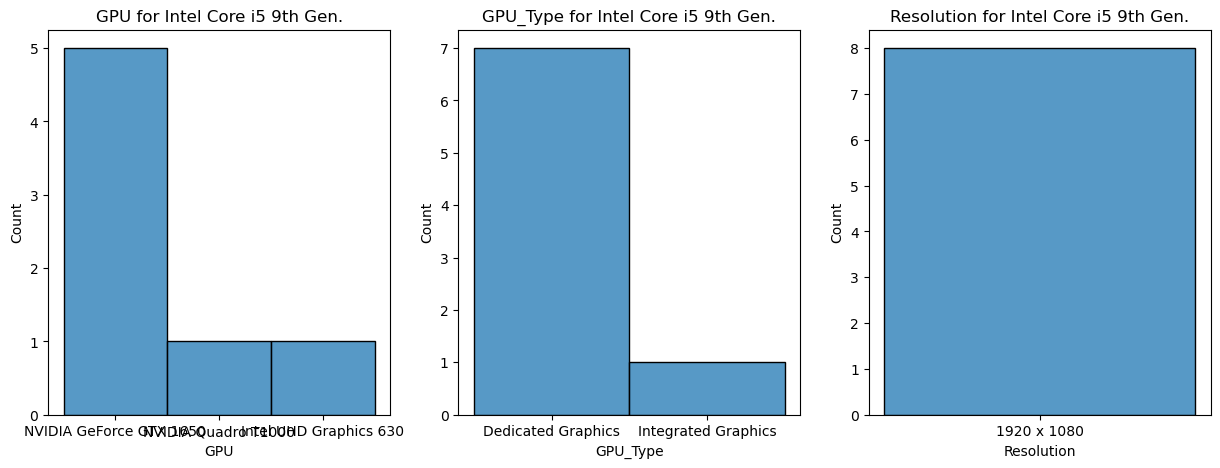

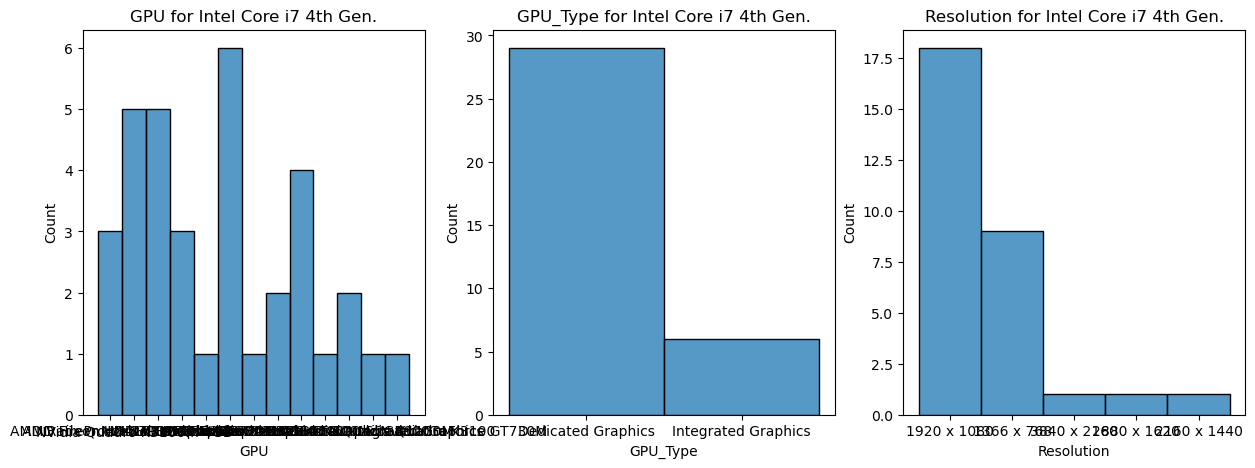

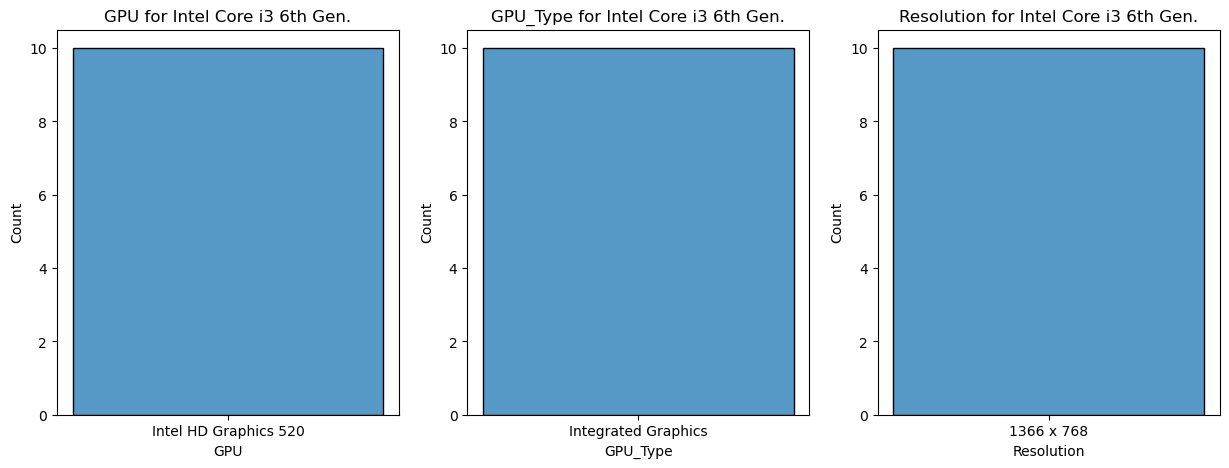

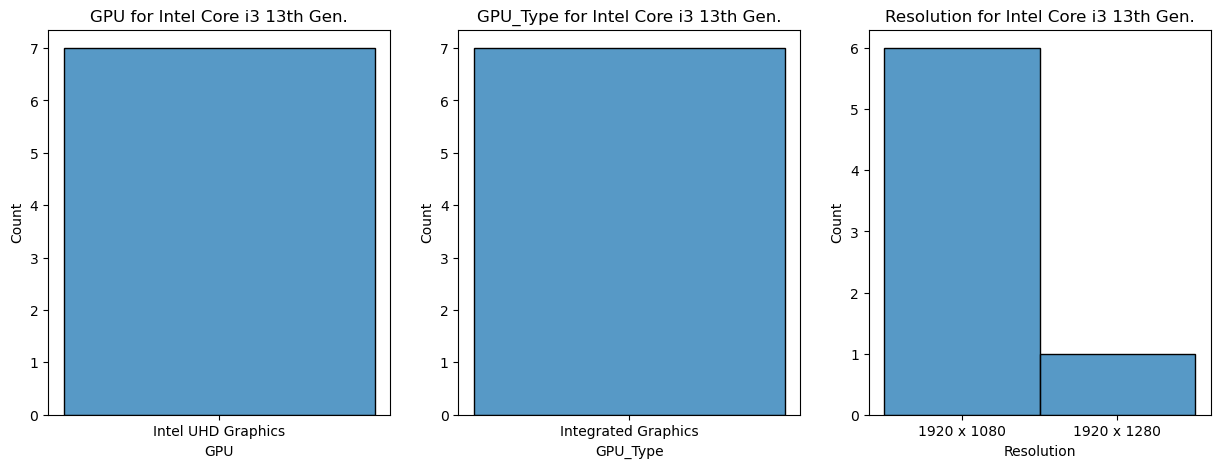

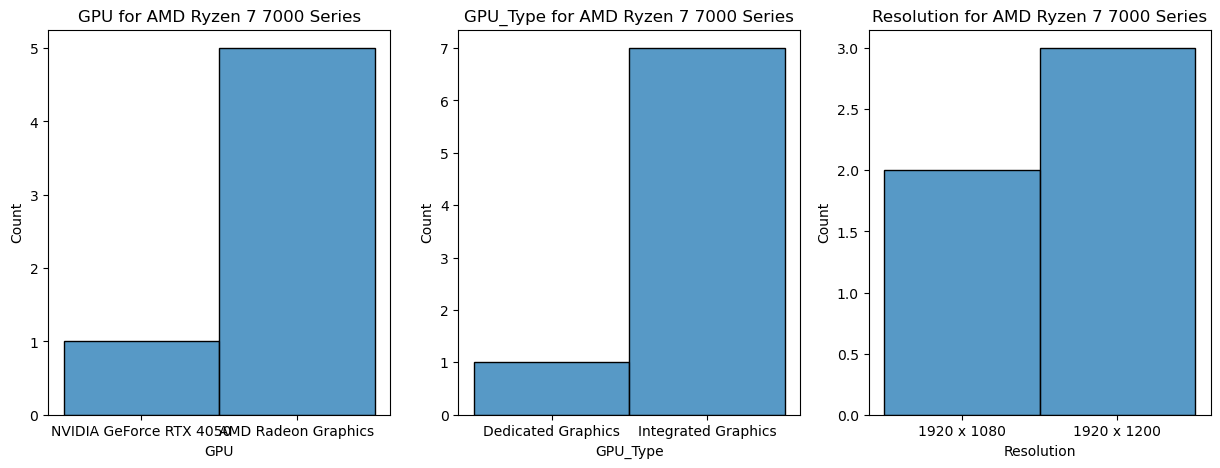

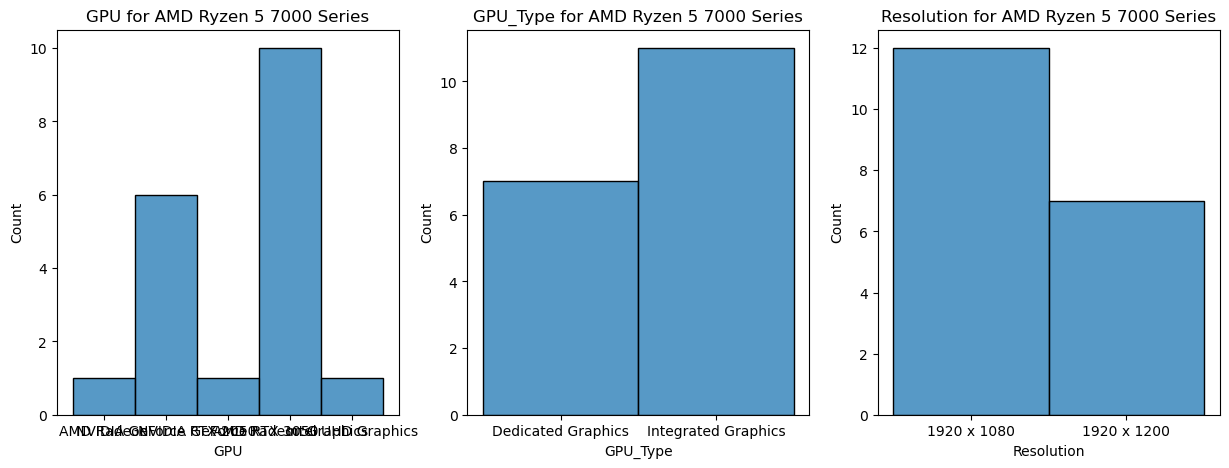

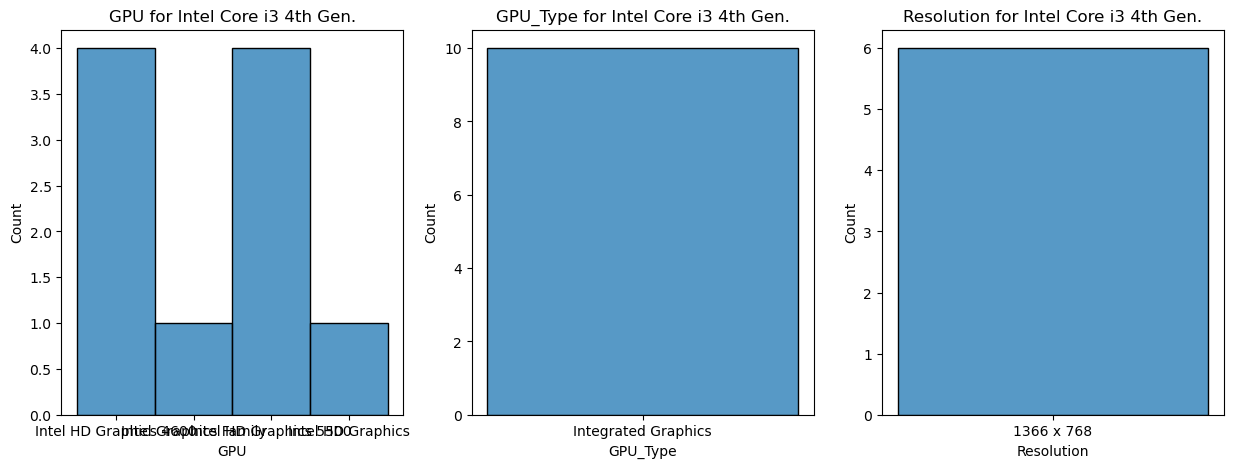

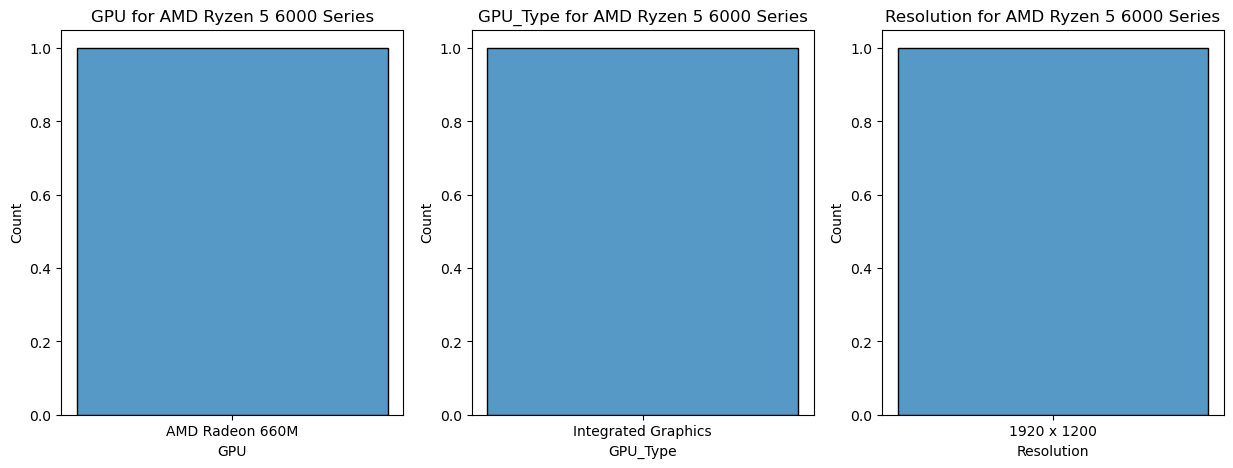

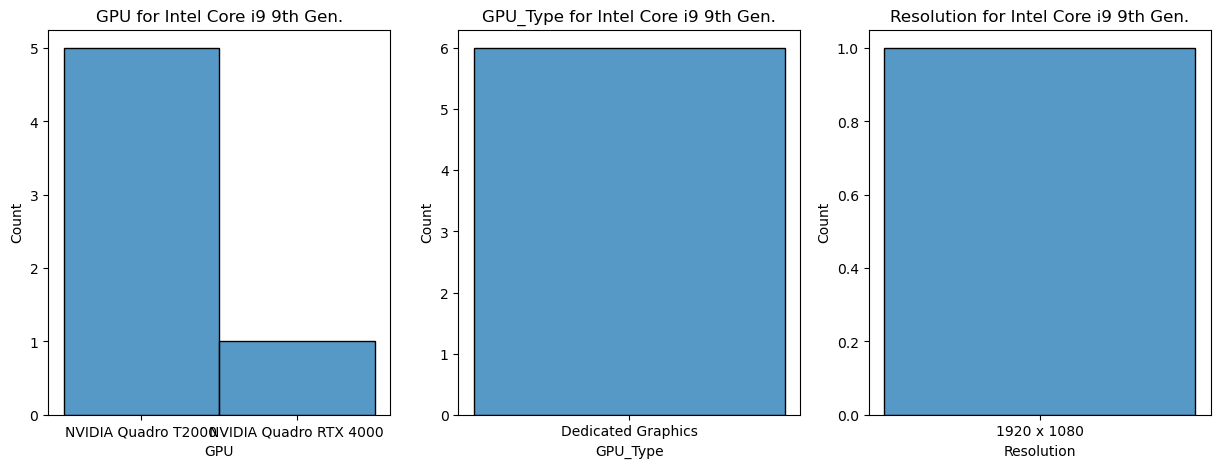

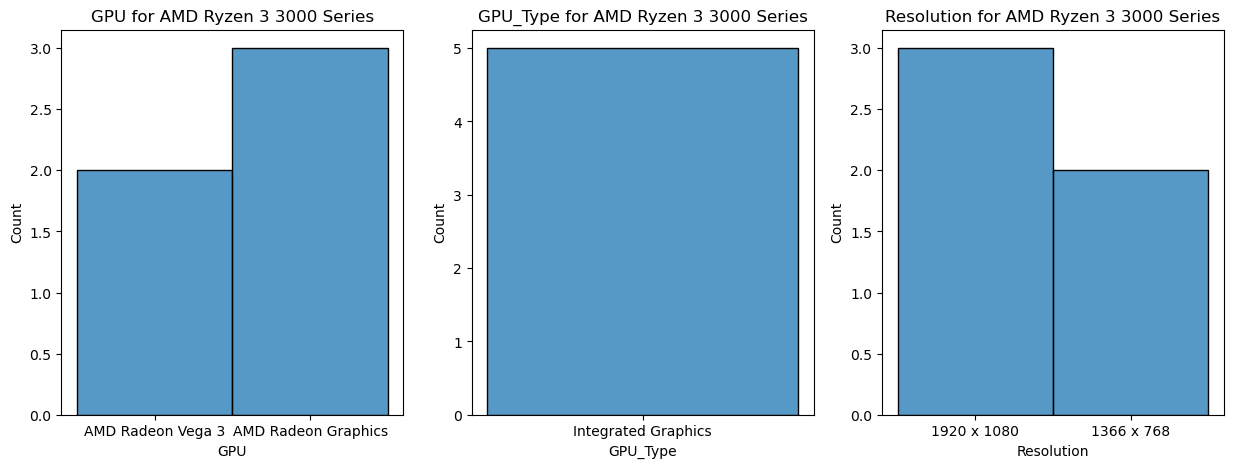

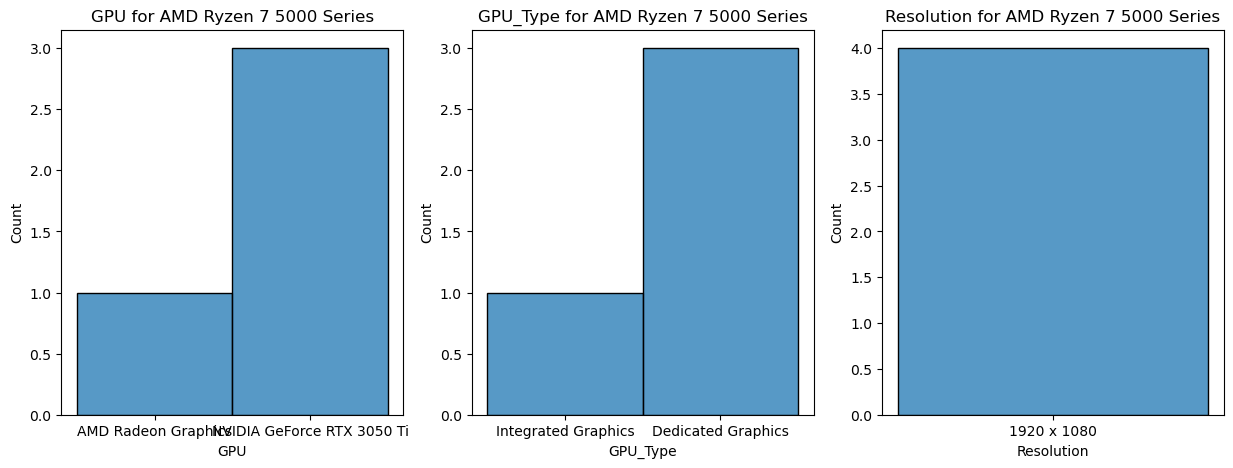

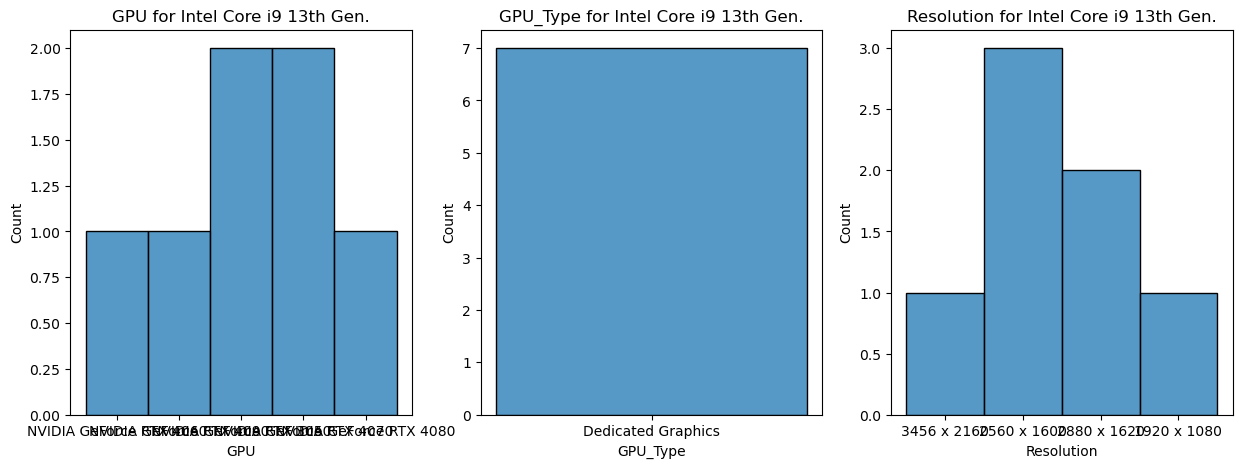

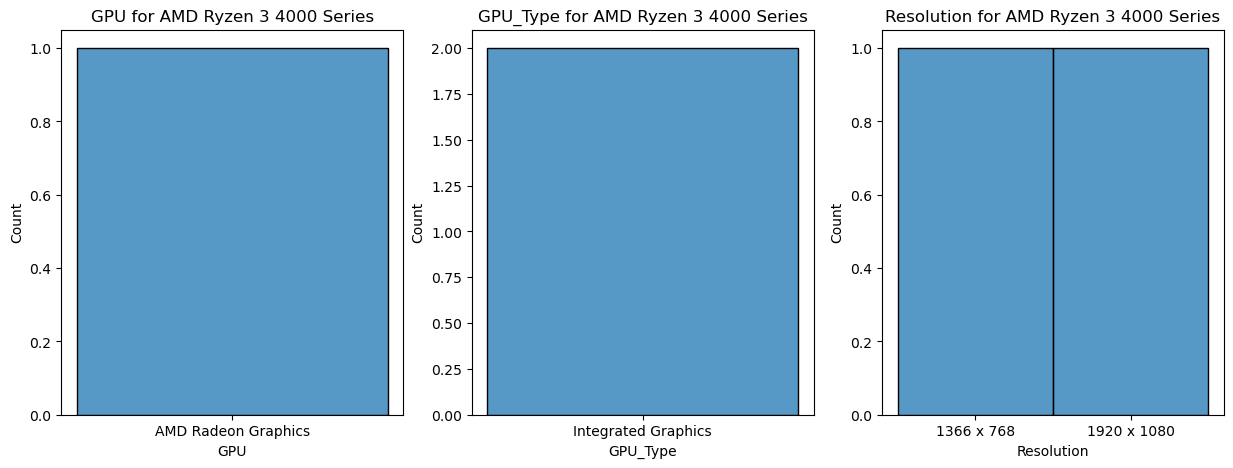

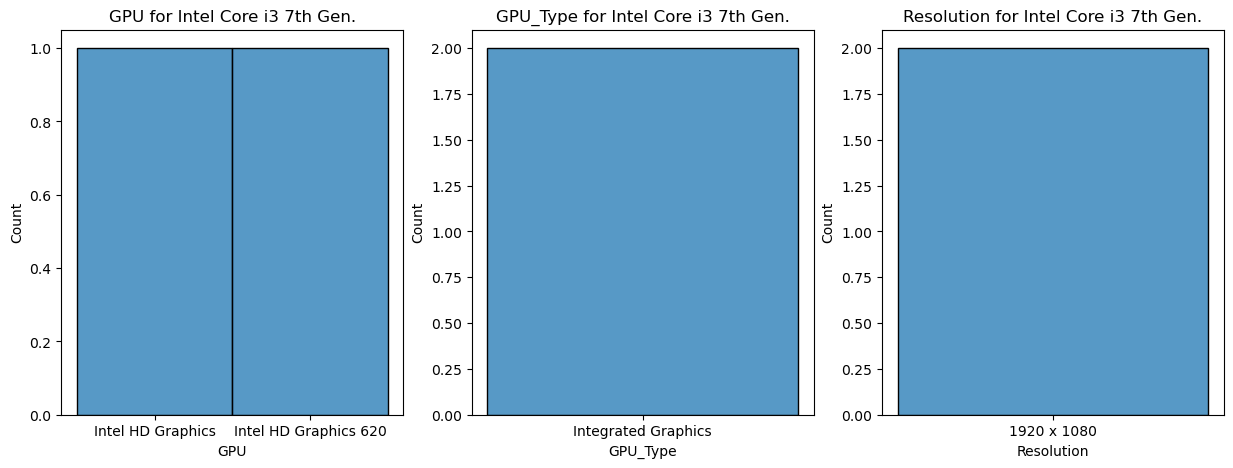

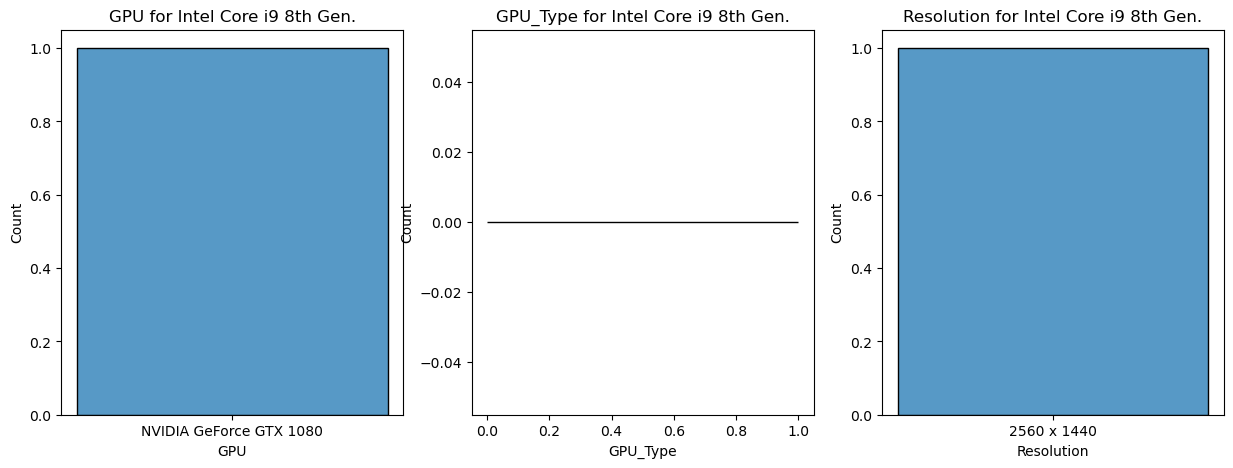

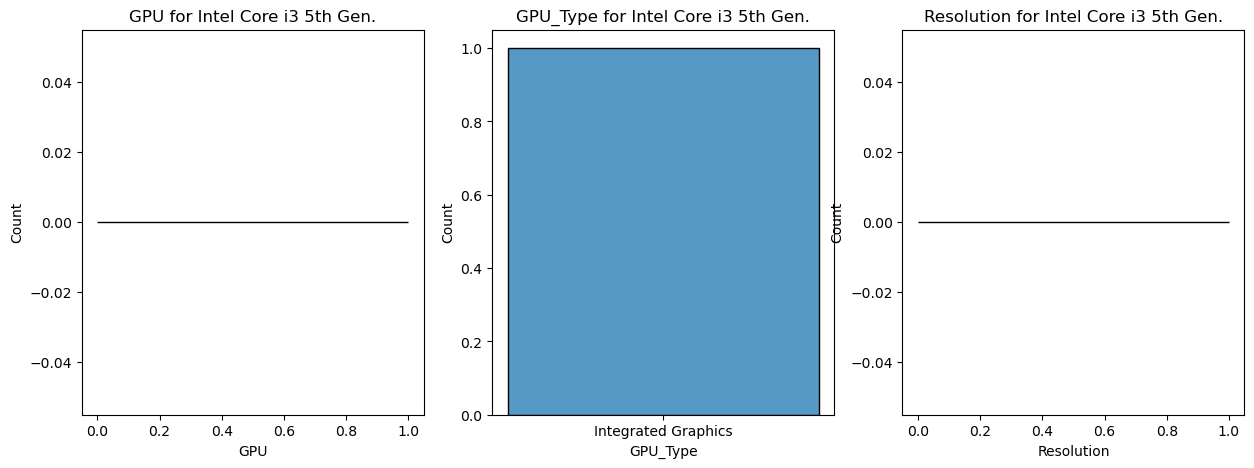

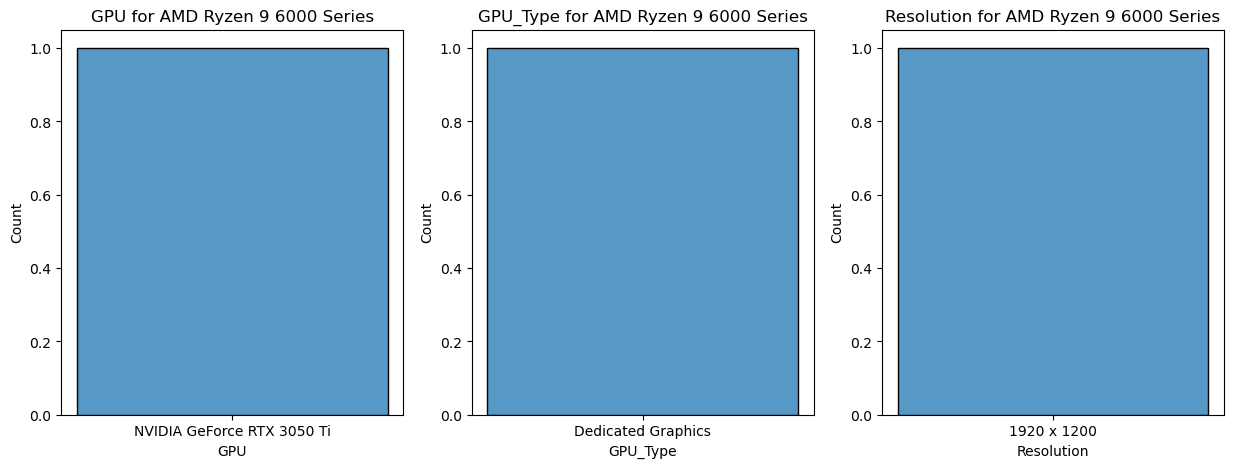

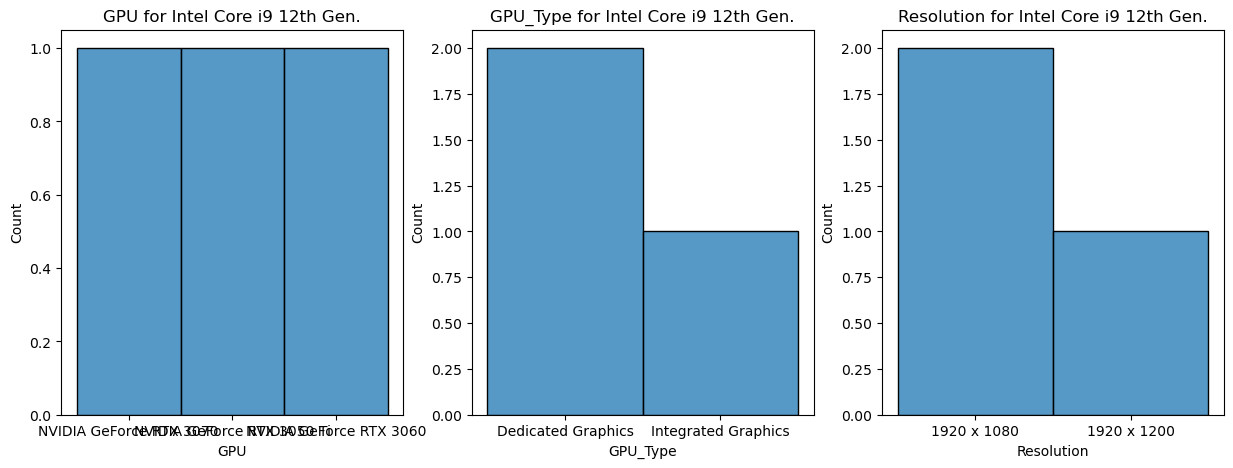

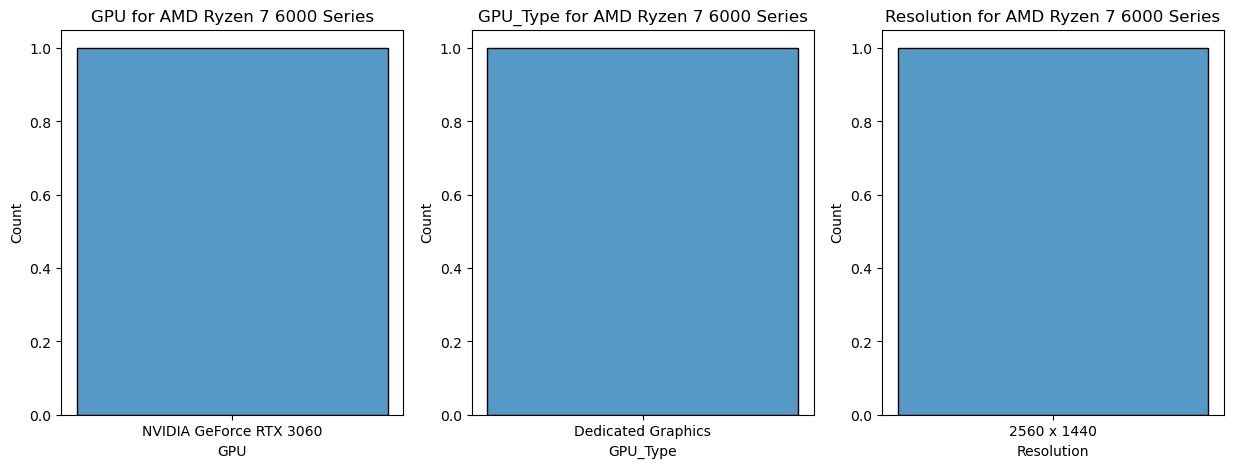

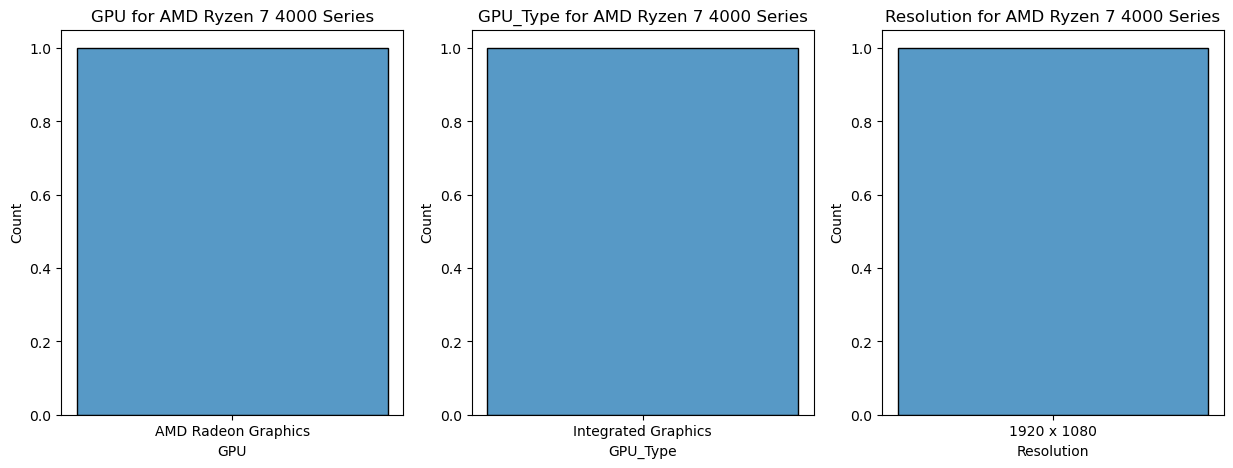

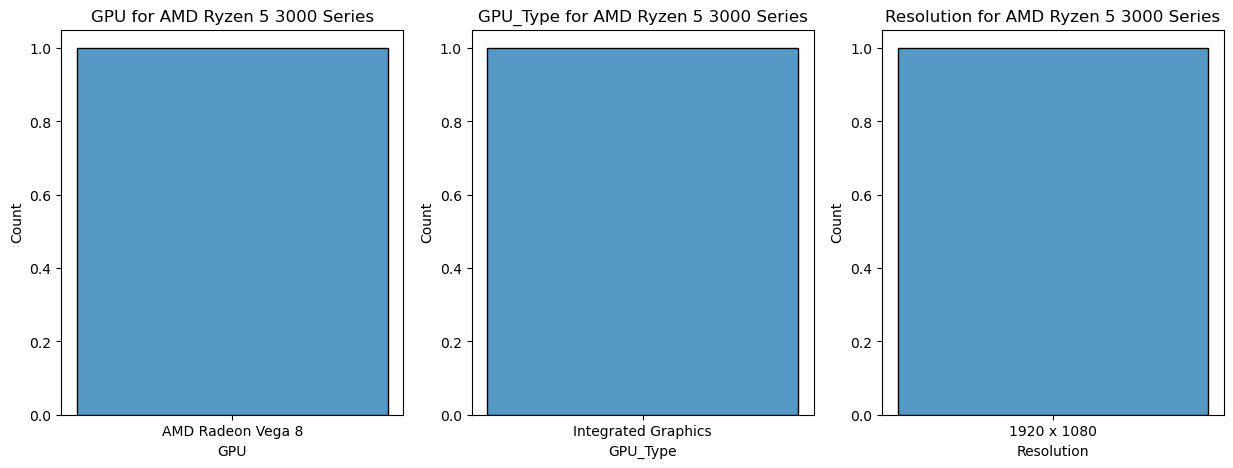

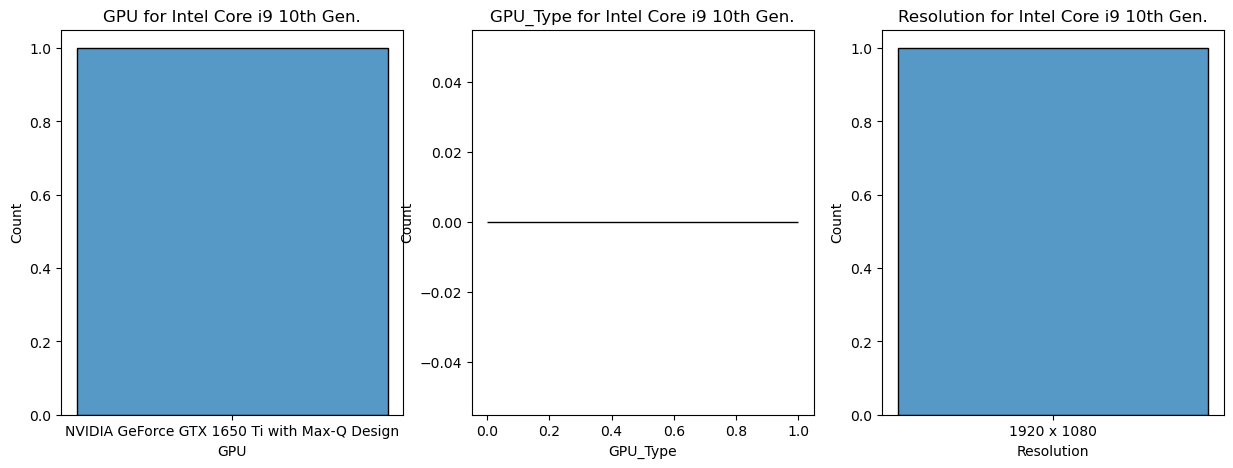

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv('/Users/edeneldar/Library/Mobile Documents/com~apple~CloudDocs/ML learn.worktrees/origin/mainEden/assignment1/assignment-1-data.csv')

# # handle midding values
# processors_catagory = data['Processor'].unique()
# len(processors_catagory)

# #  create histrograms of the data to see how each catagory is distributed for the GPU, GPU_Type, and Resolution columns under each processor type
# for processor in processors_catagory:
#     fig, ax = plt.subplots(1, 3, figsize=(15, 5))
#     for i, column in enumerate(['GPU', 'GPU_Type', 'Resolution']):
#         sns.histplot(data[data['Processor'] == processor][column], ax=ax[i])
#         ax[i].set_title(f'{column} for {processor}')
#     plt.show()



# Missing Values Handling with Mode values

In [23]:
# for each processor, find the mode of the GPU
for processor in processors_catagory:
    # if all the values of the GPU are missing, then the value will be 'Unknown'
    if data[data['Processor'] == processor]['GPU'].isnull().all():
        data.loc[data['Processor'] == processor, 'GPU'] = 'Unknown'
    else:
        mode_gpu = data[data['Processor'] == processor]['GPU'].mode()[0]
        data.loc[(data['Processor'] == processor) & (data['GPU'].isnull()), 'GPU'] = mode_gpu

# for each processor, find the mode of the GPU_Type
for processor in processors_catagory:
    if data[data['Processor'] == processor]['GPU_Type'].isnull().all():
        data.loc[data['Processor'] == processor, 'GPU_Type'] = 'Unknown'
    else:
        mode_gpu_type = data[data['Processor'] == processor]['GPU_Type'].mode()[0]
        data.loc[(data['Processor'] == processor) & (data['GPU_Type'].isnull()), 'GPU_Type'] = mode_gpu_type

# for each processor, find the mode of the Resolution
for processor in processors_catagory:
    if data[data['Processor'] == processor]['Resolution'].isnull().all():
        data.loc[data['Processor'] == processor, 'Resolution'] = 'Unknown'
    else:
        mode_resolution = data[data['Processor'] == processor]['Resolution'].mode()[0]
        data.loc[(data['Processor'] == processor) & (data['Resolution'].isnull()), 'Resolution'] = mode_resolution

In [4]:
data.head()

data = pd.DataFrame(data)

data.to_csv('/Users/edeneldar/Library/Mobile Documents/com~apple~CloudDocs/ML learn.worktrees/origin/mainEden/assignment1/missing values handled.csv', index=False)

# Dataset Splitting for Model Training

In [4]:

data = data[['Brand', 'Screen_Size', 'RAM', 'Processor', 'GPU', 'GPU_Type', 'Resolution', 'Condition', 'Price']]

# Convert categorical features to numerical values using one-hot encoding
data = pd.get_dummies(data, columns=['Brand', 'Processor', 'GPU', 'GPU_Type', 'Resolution'])

# Split the data
train_data = data.iloc[0:2058]
val_data = data.iloc[2058:2499]
test_data = data.iloc[2499:2939]

# Extract features and target variables
X_train_class = train_data.drop(columns=['Condition'])
X_train_reg = train_data.drop(columns=['Price'])
y_train_class = train_data['Condition']
y_train_reg = train_data['Price']

X_val_class = val_data.drop(columns=['Condition'])
X_val_reg = val_data.drop(columns=['Price'])
y_val_class = val_data['Condition']
y_val_reg = val_data['Price']

X_test_class = test_data.drop(columns=['Condition'])
X_test_reg = test_data.drop(columns=['Price'])
y_test_class = test_data['Condition']
y_test_reg = test_data['Price']

# Convert string labels to numerical indices
class_map = {label: idx for idx, label in enumerate(np.unique(y_train_class))}
y_train_class_numeric = np.array([class_map[label] for label in y_train_class])
y_val_class_numeric = np.array([class_map[label] for label in y_val_class])
y_test_class_numeric = np.array([class_map[label] for label in y_test_class])

# Classification Decision Tree Model

In [2]:
import numpy as np


# Decision Tree Classifier (with Gini impurity)
class DecisionTree:
    # Initialize the Decision Tree Classifier
    def __init__(self, min_samples_split=2, max_depth=5):
        # Minimum number of samples required to split an internal node
        self.min_samples_split = min_samples_split
        # Maximum depth of the tree
        self.max_depth = max_depth
        # The decision tree
        self.tree = None

    # Fit the Decision Tree Classifier
    def fit(self, X, y):
        # Convert string labels to numerical indices
        self.classes = np.unique(y)
        y = np.array([np.where(self.classes == label)[0][0] for label in y])
        # Grow the decision tree
        self.tree = self._grow_tree(X, y)
    
    # Predict the target variable for the input data
    def predict(self, X):
        predictions = [self._predict(inputs, self.tree) for inputs in X]
        # Make predictions for each input based on the decision tree that was grown
        return np.array([self.classes[pred] for pred in predictions])

    # Calculate the Gini impurity
    def _gini(self, y):
        # Number of samples
        m = len(y)
        # Return 1 - sum of the square of the proportion of samples in each class label to the total number of samples in the node
        return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in np.unique(y))

    # Split the data into left and right subsets based on the feature and threshold
    def _split(self, X, y, idx, thresh):
        # Get the indices of the samples in the left subset
        left_mask = X[:, idx] <= thresh
        # Get the indices of the samples in the right subset
        right_mask = X[:, idx] > thresh
        # Return the left and right subsets of the data
        return X[left_mask], X[right_mask], y[left_mask], y[right_mask]


    # Find the best split for the data
    def _best_split(self, X, y):
        # Number of samples (m) and number of features (n)
        m, n = X.shape

        # If the number of samples is less than or equal to the minimum number of samples required to split, return None
        if m <= 1:
            return None, None

        # Initialize the Gini impurity of the best split to infinity and the best feature and threshold to None
        best_gini = 1.0
        best_idx, best_thresh = None, None

        # For each feature
        for idx in range(n):
            # Get the thresholds and class labels
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))

            # Ensure numeric thresholds
            thresholds = np.array(thresholds, dtype=np.float64)

            num_left = [0] * len(np.unique(y))

            num_right = [np.sum(classes == c) for c in np.unique(y)]

            # For each sample
            for i in range(1, m):
                # Get the class of the sample
                c = classes[i - 1]
                # Update the number of samples in the left and right subsets
                num_left[c] += 1
                num_right[c] -= 1

                # Calculate the Gini impurity of the left and right subsets
                gini_left = 1.0 - sum((num_left[x] / i) ** 2 for x in range(len(np.unique(y))))
                gini_right = 1.0 - sum((num_right[x] / (m - i)) ** 2 for x in range(len(np.unique(y))))
                gini = (i * gini_left + (m - i) * gini_right) / m

                # Update the best split if the current split has a lower Gini impurity
                if thresholds[i] == thresholds[i - 1]:
                    continue
                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thresh = (thresholds[i] + thresholds[i - 1]) / 2
        
        # Return the best feature and threshold
        return best_idx, best_thresh

    # Grow the decision tree
    def _grow_tree(self, X, y, depth=0):
        # Get the number of samples for each class label
        num_samples_per_class = [np.sum(y == i) for i in np.unique(y)]
        # Get the class that occurs
        predicted_class = np.argmax(num_samples_per_class)
        # Create a node for the decision tree
        node = {'predicted_class': predicted_class}

        # If the depth of the tree is less than the maximum depth
        if depth < self.max_depth:
            # Get the best split
            idx, thresh = self._best_split(X, y)
            # If the best split is not None
            if idx is not None:
                # Get the left and right subsets of the data
                indices_left = X[:, idx] <= thresh
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                # Grow the left and right subtrees
                node['feature_index'] = idx
                node['threshold'] = thresh
                node['left'] = self._grow_tree(X_left, y_left, depth + 1)
                node['right'] = self._grow_tree(X_right, y_right, depth + 1)
        return node

    # Predict the target variable for the input data
    def _predict(self, inputs, tree):
        # If the tree is not a leaf node
        if 'threshold' in tree:
            # Get the feature index and threshold
            feature_index = tree['feature_index']
            # Traverse the left or right subtree
            if inputs[feature_index] <= tree['threshold']:
                return self._predict(inputs, tree['left'])
            else:
                return self._predict(inputs, tree['right'])
        # If the tree is a leaf node
        else:
            # Return the predicted class
            return tree['predicted_class']







# Regression Decision Tree Model

In [3]:
# Decision Tree Regressor (with SSR)
class DecisionTreeRegressor(DecisionTree):
    # Initialize the Decision Tree Regressor that inherits from the Decision Tree Classifier
    def _ssr(self, y):
        if len(y) == 0:
            return 0
        mean_y = np.mean(y)
        # Calculate the sum of the squared residuals and return it
        return np.sum((y - mean_y) ** 2)

    # Find the best split for the data based on the sum of the squared residuals
    def _best_split(self, X, y):

        # Number of samples (m) and number of features (n)
        m, n = X.shape

        # If the number of samples is less than or equal to the minimum number of samples required to split, return None
        if m <= 1:
            return None, None

        # Initialize the sum of the squared residuals of the best split to infinity and the best feature and threshold to None
        best_ssr = np.inf
        best_idx, best_thresh = None, None

        # For each feature
        for idx in range(n):
            # Get the thresholds and values
            thresholds, values = zip(*sorted(zip(X[:, idx], y)))
            # For each sample
            for i in range(1, m):
                # Get the left and right subsets of the target variable
                y_left, y_right = values[:i], values[i:]
                ssr_left, ssr_right = self._ssr(y_left), self._ssr(y_right)

                # Calculate the sum of the squared residuals of the left and right subsets
                ssr = ssr_left + ssr_right

                # Update the best split if the current split has a lower sum of the squared residuals
                if thresholds[i] == thresholds[i - 1]:
                    continue
                if ssr < best_ssr:
                    best_ssr = ssr
                    best_idx = idx
                    best_thresh = (thresholds[i] + thresholds[i - 1]) / 2

        # Return the best feature and threshold
        return best_idx, best_thresh

# Classification Decision Tree Model Training and Prediction

In [ ]:
# Train and evaluate Decision Tree Classifier with max_depth=5
dt_classifier = DecisionTree(max_depth=5)
dt_classifier.fit(X_train_class.values, y_train_class_numeric)
predictions = dt_classifier.predict(X_val_class.values)
accuracy = np.mean(predictions == y_val_class_numeric)
print(f'Validation Accuracy: {accuracy}')

# Regression Decision Tree Model Training and Prediction

In [5]:
# Train and evaluate Decision Tree Regressor with max_depth=5
dt_regressor = DecisionTreeRegressor(max_depth=5)

# Fit the Decision Tree Regressor to the training data
dt_regressor.fit(X_train_reg.values, y_train_reg.values)

# Make predictions on the validation data
predictions = dt_regressor.predict(X_val_reg.values)

# Calculate the mean squared error of the model
mse = np.mean((predictions - y_val_reg.values) ** 2)
print(f'Validation MSE: {mse}')

TypeError: unsupported operand type(s) for /: 'str' and 'int'

# Random Forest Model

In [ ]:
class RandomForest:
    def __init__(self, n_trees=100, max_depth=5, min_samples_split=2, n_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        n_samples, n_features = X.shape
        self.n_features = self.n_features or n_features
        for _ in range(self.n_trees):
            idxs = np.random.choice(n_samples, n_samples, replace=True)
            tree = DecisionTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            tree.fit(X[idxs], y[idxs])
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(tree_preds, axis=0)

# Train and evaluate Random Forest Classifier
rf_classifier = RandomForest(n_trees=100, max_depth=5)
rf_classifier.fit(X_train.values, y_train_class_numeric)
predictions = rf_classifier.predict(X_val.values)
accuracy = np.mean(predictions == y_val_class_numeric)
print(f'Validation Accuracy: {accuracy}')

# Random Forest Regressor (with averaging)
class RandomForestRegressor(RandomForest):
    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(tree_preds, axis=0)

# Train and evaluate Random Forest Regressor
rf_regressor = RandomForestRegressor(n_trees=100, max_depth=5)
rf_regressor.fit(X_train.values, y_train_reg.values)
predictions = rf_regressor.predict(X_val.values)
mse = np.mean((predictions - y_val_reg.values) ** 2)
print(f'Validation MSE: {mse}')